In [1]:
import pprint
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs
import mysql.connector
import pandas as pd
from getpass import getpass
from mysql.connector import connect, Error
import collections
from typing import Optional, List
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


# Connect to database
try:
    with connect(
        host="localhost",
        user="root",
        password="mysql",
        database="Sprint1BasicEComDb"
    ) as connection:
        print(connection)
except Error as e:
    print(e)
    
def save_to_csv(data, filename, header):
    df = pd.DataFrame(data).set_axis(header, axis=1)
    df.to_csv(filename, index=False, )

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prep-Data

In [2]:
def sample_listwise_2(
    rating_dataset: tf.data.Dataset,
    user_features: List[str],
    book_features: List[str],
    num_list_per_user: int = 50,
    num_examples_per_list: int = 5,
    seed: Optional[int] = None
) -> tf.data.Dataset:
    """Convert a dataset to a listwise dataset with user and book features."""
    random_state = np.random.RandomState(seed)
    example_lists_by_user = collections.defaultdict(
        lambda: collections.defaultdict(list))

    # Collect features for each user
    for example in rating_dataset.as_numpy_iterator():
        user_id = example["user_id"]
        for feature in user_features + book_features + ["user_rating"]:
            example_lists_by_user[user_id][feature].append(example[feature])

    structured_lists = []
    # Build structured lists for each user
    for user_id, feature_lists in example_lists_by_user.items():
        for _ in range(num_list_per_user):
            if len(feature_lists["book_id"]) < num_examples_per_list:
                continue  # Skip users with fewer books than required for a full list

            sampled_indices = random_state.choice(len(feature_lists["book_id"]),
                                                  size=num_examples_per_list,
                                                  replace=False)

            list_entry = {feature: []
                          for feature in user_features + book_features + ["user_rating"]}
            for feature in book_features + ["user_rating"]:
                for i in sampled_indices:
                    list_entry[feature].append(feature_lists[feature][i])

            # Add user features (assumed to be the same for all books in the list)
            for feature in user_features:
                list_entry[feature] = feature_lists[feature][0]

            structured_lists.append(list_entry)
    def generator():
        for entry in structured_lists:
            # Convert lists for listwise features to the required fixed length
            # Ensure single-value features are correctly formatted
            # This assumes `entry` is already structured to match these expectations
            yield entry
    output_types = {
        'book_id': tf.int64,
        'book_title': tf.string,
        'user_rating': tf.float32,
        'user_id': tf.int64,
        'sex': tf.int64  # Assuming 'sex' is an example of a single-value user feature
    }
    output_shapes = {
        'book_id': (num_examples_per_list,),
        'book_title': (num_examples_per_list,),
        'user_rating': (num_examples_per_list,),
        'user_id': (),
        'sex': ()  # Ensure shapes are specified for all features
    }
    # Create the dataset with known types and shapes
    return tf.data.Dataset.from_generator(generator, output_types=output_types, output_shapes=output_shapes)

# Output looks like:
# userA:{
    # book_id: [1, 2, 3, 4, 5],
    # book_title: ['Book1', 'Book2', 'Book3', 'Book4', 'Book5'],
    # user_rating: [5, 4, 3, 2, 1],
#}

In [3]:
def get_all_books_user_and_ratings():  # TODO: like get All Books, add attributes to the query
    query = """SELECT 
    u.id AS userid,   -- User ID
    u.sex,            -- User sex
    b.id AS bookid,   -- Book ID
    b.book,           -- Book title or name
    ubr.rating AS user_rating  -- User's rating of the book
    FROM userbookratings ubr
    JOIN users u ON ubr.userid = u.id
    JOIN bookitems b ON ubr.bookid = b.id; """
    # incase connection is lost, reconnect
    connection.reconnect(attempts=3, delay=5)
    mydb = connection.cursor()
    mydb.execute(query)
    user_ratings = mydb.fetchall()
    return user_ratings


print()
save_to_csv(get_all_books_user_and_ratings(), '../User_book_Ratings.csv',
            ['user_id', 'sex', 'book_id', 'book_title', 'user_rating'])

rating_rank = pd.read_csv('../User_book_Ratings.csv')
rating_rank = rating_rank.dropna()

In [4]:
# all the ones I want to use
user_features = ['userid', 'birthdate', 'sex',
                 'genrePreference', 'authorPreference']
book_features = ['book_id', 'book_title', 'description',
                 'num_page', 'pre_rating', 'publication', 'authorids', 'genreids']
# the ones I'm ac
user_features = ['user_id', 'sex']
book_features = ['book_id', 'book_title']



# convert dataframe to tf.data.Dataset
rating_rank = tf.data.Dataset.from_tensor_slices(dict(rating_rank))# LINE CAN ONLY BE USED 1NCE

# TODO: Add more features to the dataset
rating_rank = rating_rank.map(lambda x: {
    "user_id": x["user_id"],
    "sex": x['sex'],
    "book_id": x['book_id'],
    "book_title": x['book_title'],
    "user_rating": x["user_rating"],
    }
)

book_ids = rating_rank.batch(1_000_000).map(lambda x: x["book_id"])
unique_book_ids = np.unique(np.concatenate(list(book_ids)))

book_titles = rating_rank.batch(1_000_000).map(lambda x: x["book_title"])
unique_book_titles = np.unique(np.concatenate(list(book_titles)))

user_ids = rating_rank.batch(1_000_000).map(lambda x: x["user_id"])
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

tf.random.set_seed(42)
print(len(rating_rank))
shuffled = rating_rank.shuffle(100, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(70)
test = shuffled.skip(70).take(30)

train = sample_listwise_2(train, user_features, book_features,
                              num_list_per_user=50, num_examples_per_list=5, seed=42)

test = sample_listwise_2(test, user_features, book_features,
                             num_list_per_user=1, num_examples_per_list=5, seed=42)

cached_train = train.shuffle(70).batch(32, drop_remainder=True).cache()

cached_test = test.batch(32).cache()



1000


# Pre-Process Data

In [5]:

#book_id
book_id_lookup = tf.keras.layers.IntegerLookup()
book_id_lookup.adapt(unique_book_ids) 

# Book title 
book_title_lookup = tf.keras.layers.StringLookup()
book_title_lookup.adapt(unique_book_titles)




In [6]:
class BookModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.book_id_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_book_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_book_ids) + 1, 32)
        ])

        self.book_title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_book_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_book_titles) + 1, 32)
        ])

    def call(self, inputs):
        # print("Model input keys:", list(inputs.keys()))
        # for key, value in inputs.items():
        #     print(f"Shape of {key}:", value.shape)
        return tf.concat([
            self.book_id_embedding(inputs["book_id"]),
            self.book_title_embedding(inputs["book_title"]),
            # self.num_pages_embedding(inputs["num_pages"]),
        ], axis=-1)

    def get_config(self):
        config = super(BookModel, self).get_config()
        config.update({
            "unique_book_ids": self.book_id_embedding.layers[0].get_vocabulary(),
            "unique_book_titles": self.book_title_embedding.layers[0].get_vocabulary()
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [7]:

user_id_lookup = tf.keras.layers.IntegerLookup()
user_id_lookup.adapt(unique_user_ids)


In [8]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.user_id_embedding = tf.keras.Sequential([
            user_id_lookup,
            tf.keras.layers.Embedding(user_id_lookup.vocabulary_size(), 32),
        ])
        
        # Assuming sex is represented as 0 or 1
        self.sex_embedding = tf.keras.layers.Embedding(
            2, 32)  

    def call(self, inputs):
        #print("Model input keys:", list(inputs.keys()))
        #for key, value in inputs.items():
        #    print(f"Shape of {key}:", value.shape)

        user_id_feature = self.user_id_embedding(inputs["user_id"])
        sex_feature = self.sex_embedding(
            tf.cast(inputs["sex"], tf.int32))  # Corrected attribute name

        return tf.concat([
            user_id_feature,
            sex_feature,
        ], axis=1)

    def get_config(self):
        config = super(UserModel, self).get_config()
        config.update({
            "user_ids_vocabulary": self.user_id_embedding.layers[0].get_vocabulary(),
            "sex_embedding_dim": self.sex_embedding.output_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Ranking Model

In [9]:
class RankingModel(tfrs.Model):

    def __init__(self, loss):
        super().__init__()
        embedding_dimension = 32

        # User embeddings
        self.user_embeddings = tf.keras.Sequential([
            UserModel()
            ])
        # Restaurand embeddings
        self.book_embeddings = tf.keras.Sequential([
            BookModel(),
            
        ])
        # Compute predictions
        self.score_model = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid"),  # Sigmoid activation to ensure output is between 0 and 1
            tf.keras.layers.Lambda(lambda x: x * 5)  # Scale up by 5 to adjust the range to 0-5

        ])

        self.task = tfrs.tasks.Ranking(
            loss=loss,
            metrics=[
                tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
                tf.keras.metrics.RootMeanSquaredError()
            ]
        )

    def call(self, features):
        # Extract user embeddings [batch_size, embedding_dim].
        user_embeddings = self.user_embeddings({
            'user_id': features['user_id'],
            'sex': features['sex'],
        })

        # Extract book embeddings [batch_size, num_books, embedding_dim].
        book_embeddings = self.book_embeddings({
            'book_id': features['book_id'],
            'book_title': features['book_title'],
            # Potentially include other book features here
        })

        
        list_length = features['book_id'].shape[1]

        user_embedding_repeated = tf.repeat(
            tf.expand_dims(user_embeddings, 1), [list_length], axis=1)

        #print("User Embedding Repeated Shape:", user_embedding_repeated.shape)
        #print("Book Embeddings Shape:", book_embeddings.shape)

        # Concatenate user and book embeddings along the last dimension.
        combined_embeddings = tf.concat(
            [user_embedding_repeated, book_embeddings], axis=2)

        combined_embeddings_flat = tf.reshape(combined_embeddings, [tf.shape(combined_embeddings)[0] * list_length, -1])

        # Passing the flattened embeddings to the scoring model.
        scores_flat = self.score_model(combined_embeddings_flat)

        # Reshaping scores to match the labels shape (10, 5)
        scores = tf.reshape(scores_flat, [tf.shape(features['book_id'])[0], list_length])
        return scores

    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )

# Train Model

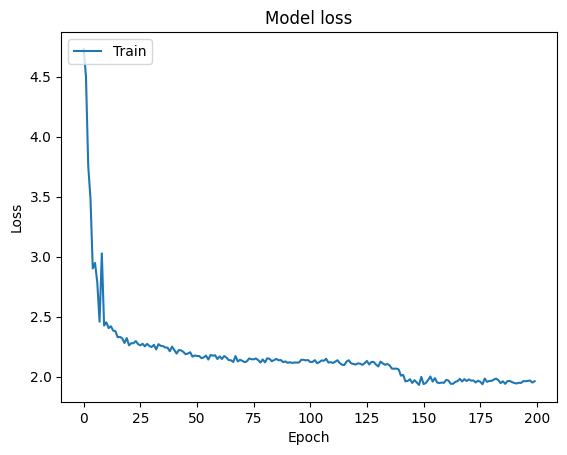

In [10]:
listwise_model = RankingModel(tfr.keras.losses.ListMLELoss())
listwise_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history=listwise_model.fit(cached_train, epochs=200, verbose=False)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
#test
listwise_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 1s 1s/step - ndcg_metric: 0.8119 - root_mean_squared_error: 2.4338 - loss: 7.5191 - regularization_loss: 0.0000e+00 - total_loss: 7.5191


{'ndcg_metric': 0.8119218945503235,
 'root_mean_squared_error': 2.4338083267211914,
 'loss': 7.519116401672363,
 'regularization_loss': 0,
 'total_loss': 7.519116401672363}

In [12]:
listwise_model.save("../../RESTful API/listwise_model", save_format='tf')

INFO:tensorflow:Assets written to: ../../RESTful API/listwise_model\assets


INFO:tensorflow:Assets written to: ../../RESTful API/listwise_model\assets


In [13]:

loaded_model = load_model('export', custom_objects={
    'UserModel': UserModel,
    'BookModel': BookModel,
    'RankingModel': RankingModel,
    'NDCGMetric': tfr.keras.metrics.NDCGMetric
})


loaded_model({
    "user_id": tf.constant([1], dtype=tf.int64),  # Ensure dtype is tf.int64
    # Ensure dtype is tf.int64 # Ensure dtype is tf.int64
    "sex": tf.constant([0], dtype=tf.int64),
    "book_id": tf.constant([[101, 102, 103, 104, 105]], dtype=tf.int64),
    "book_title": tf.constant([
        ["the lord god made them all",
         "noble house",
         "scary stories to tell in the dark",
         "god emperor of dune",
         "st peters fair"
         ]])
}, training=False),

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[2.8021364, 2.6535563, 3.0276036, 2.7775326, 2.9007573]],
       dtype=float32)>,)